# 네이버 검색어 트렌드 복수 단어
## 01. 작업 준비
#### 패키지 참조

In [11]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

In [12]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False


## 02. 네이버 검색어 트렌드 OpenAPI 연동
### 접속에 필요한 정보 설정
#### API URL

In [13]:
API_URL = "https://openapi.naver.com/v1/datalab/search"


#### 발급받은 인증키

In [14]:
client_id = "sNbt9TXmxIhzvKuTm7_s"
client_secret = "fdgWacl2JY"

#### 접속 객체 생성

In [15]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

#### 전달할 검색어 구성

In [24]:
data = {
    "startDate": "2021-07-01",   # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "date",         # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "Meta",  # 검색주제
            "keywords": ["meta", "메타버스", "오큘러스", "오큘러스3"]   # 주제와 관련된 검색어
        },
        {
            "groupName": "애플",  # 검색주제
            "keywords": ["visionPro", "아이폰", "팀쿡", "맥북"]   # 주제와 관련된 검색어
        }
    ]
}


#### 데이터 요청하기

In [25]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2021-07-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': 'Meta',
   'keywords': ['meta', '메타버스', '오큘러스', '오큘러스3'],
   'data': [{'period': '2021-07-01', 'ratio': 15.15996},
    {'period': '2021-07-02', 'ratio': 13.24348},
    {'period': '2021-07-03', 'ratio': 18.63089},
    {'period': '2021-07-04', 'ratio': 12.21134},
    {'period': '2021-07-05', 'ratio': 20.08486},
    {'period': '2021-07-06', 'ratio': 19.47537},
    {'period': '2021-07-07', 'ratio': 18.14762},
    {'period': '2021-07-08', 'ratio': 17.73243},
    {'period': '2021-07-09', 'ratio': 14.09212},
    {'period': '2021-07-10', 'ratio': 11.19414},
    {'period': '2021-07-11', 'ratio': 10.53317},
    {'period': '2021-07-12', 'ratio': 20.04915},
    {'period': '2021-07-13', 'ratio': 21.69494},
    {'period': '2021-07-14', 'ratio': 24.43929},
    {'period': '2021-07-15', 'ratio': 27.18614},
    {'period': '2021-07-16', 'ratio': 27.33145},
    {'period': '2021-07-17', 'ratio': 16.17218},
   

In [26]:
print("검색 결과 수 :", len(mydict['results']))


검색 결과 수 : 2


In [27]:
title1 = mydict['results'][0]['title']
print(title1)

data = mydict['results'][0]['data']
df1 = DataFrame(data)
df1.rename(columns={'ratio':title1}, inplace=True)
df1.head()


Meta


,period,Meta
0,2021-07-01,15.15996
1,2021-07-02,13.24348
2,2021-07-03,18.63089
3,2021-07-04,12.21134
4,2021-07-05,20.08486


In [28]:
title2 = mydict['results'][1]['title']
print(title2)

data = mydict['results'][1]['data']
df2 = DataFrame(data)
df2.rename(columns={'ratio':title2}, inplace=True)
df2.head()


애플


,period,애플
0,2021-07-01,14.45499
1,2021-07-02,14.03565
2,2021-07-03,14.06804
3,2021-07-04,14.69745
4,2021-07-05,14.92663


In [30]:
df = merge(df1, df2, how='outer')
df.head()


,period,Meta,애플
0,2021-07-01,15.15996,14.45499
1,2021-07-02,13.24348,14.03565
2,2021-07-03,18.63089,14.06804
3,2021-07-04,12.21134,14.69745
4,2021-07-05,20.08486,14.92663


In [31]:
df.dtypes

period     object
Meta      float64
애플        float64
dtype: object

In [32]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2


,Meta,애플
2021-07-01,15.15996,14.45499
2021-07-02,13.24348,14.03565
2021-07-03,18.63089,14.06804
2021-07-04,12.21134,14.69745
2021-07-05,20.08486,14.92663
...,...,...
2023-07-27,2.97021,12.21881
2023-07-28,2.57662,11.05713
2023-07-29,1.79275,10.83958
2023-07-30,1.73380,11.15761


In [33]:
df3 = df2.reset_index()
df3.head()

,index,Meta,애플
0,2021-07-01,15.15996,14.45499
1,2021-07-02,13.24348,14.03565
2,2021-07-03,18.63089,14.06804
3,2021-07-04,12.21134,14.69745
4,2021-07-05,20.08486,14.92663


In [35]:
df4 = melt(df3, id_vars=['index'], value_vars=['Meta','애플'], var_name='키워드', value_name='검색량')
df4.set_index('index', inplace=True)
df4.head()

,키워드,검색량
index,,
2021-07-01,Meta,15.15996
2021-07-02,Meta,13.24348
2021-07-03,Meta,18.63089
2021-07-04,Meta,12.21134
2021-07-05,Meta,20.08486


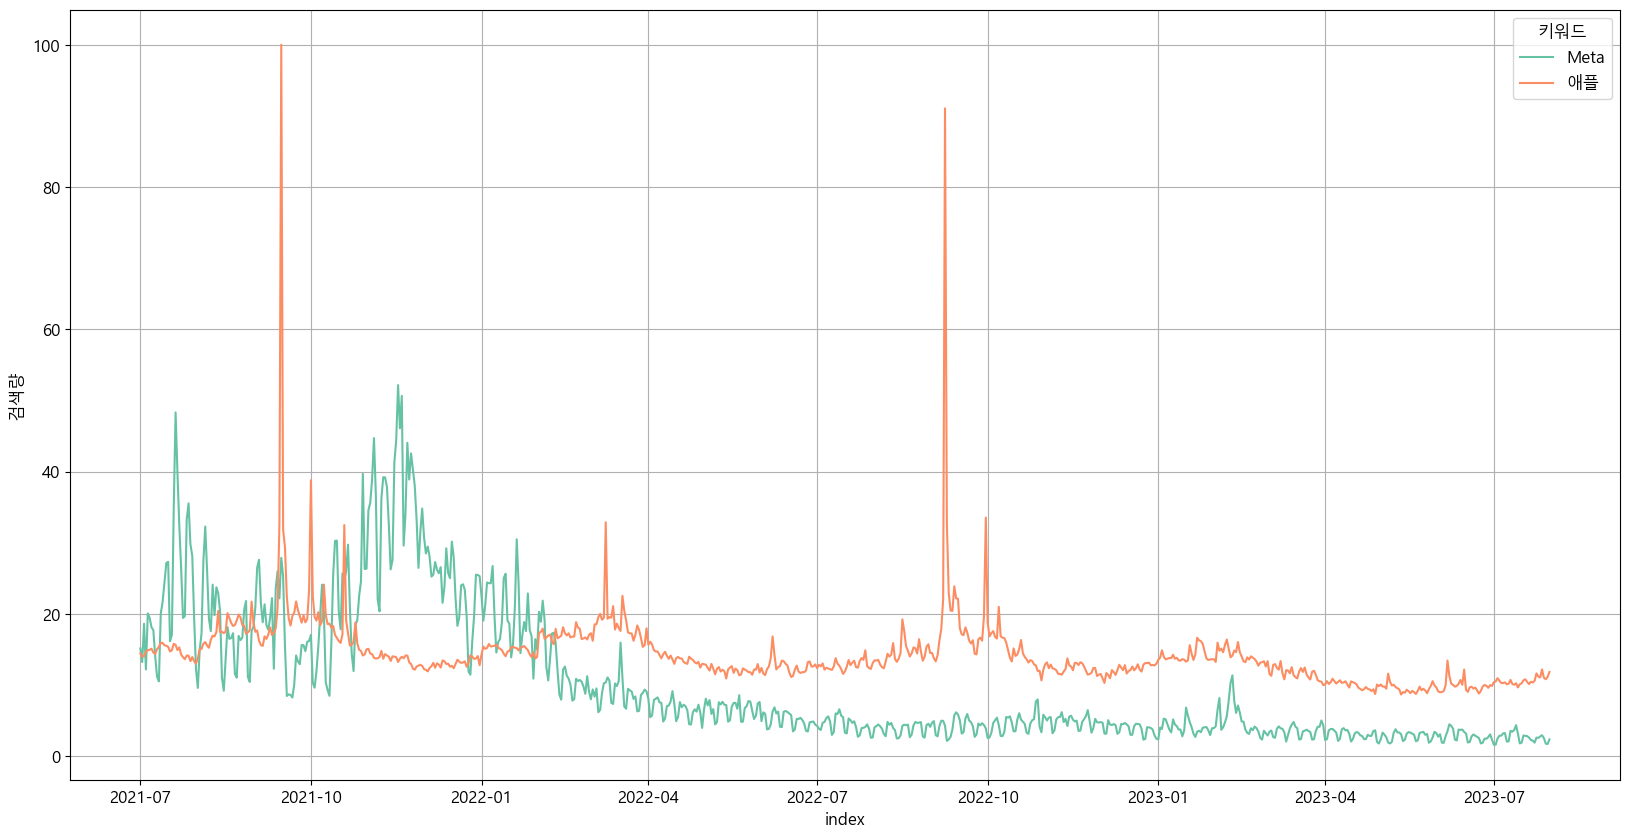

In [36]:
plt.figure(figsize=(20, 10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

Meta
결측치 수: 0


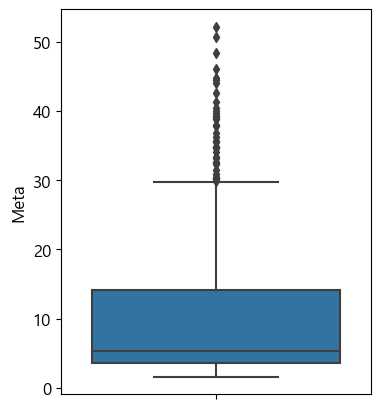

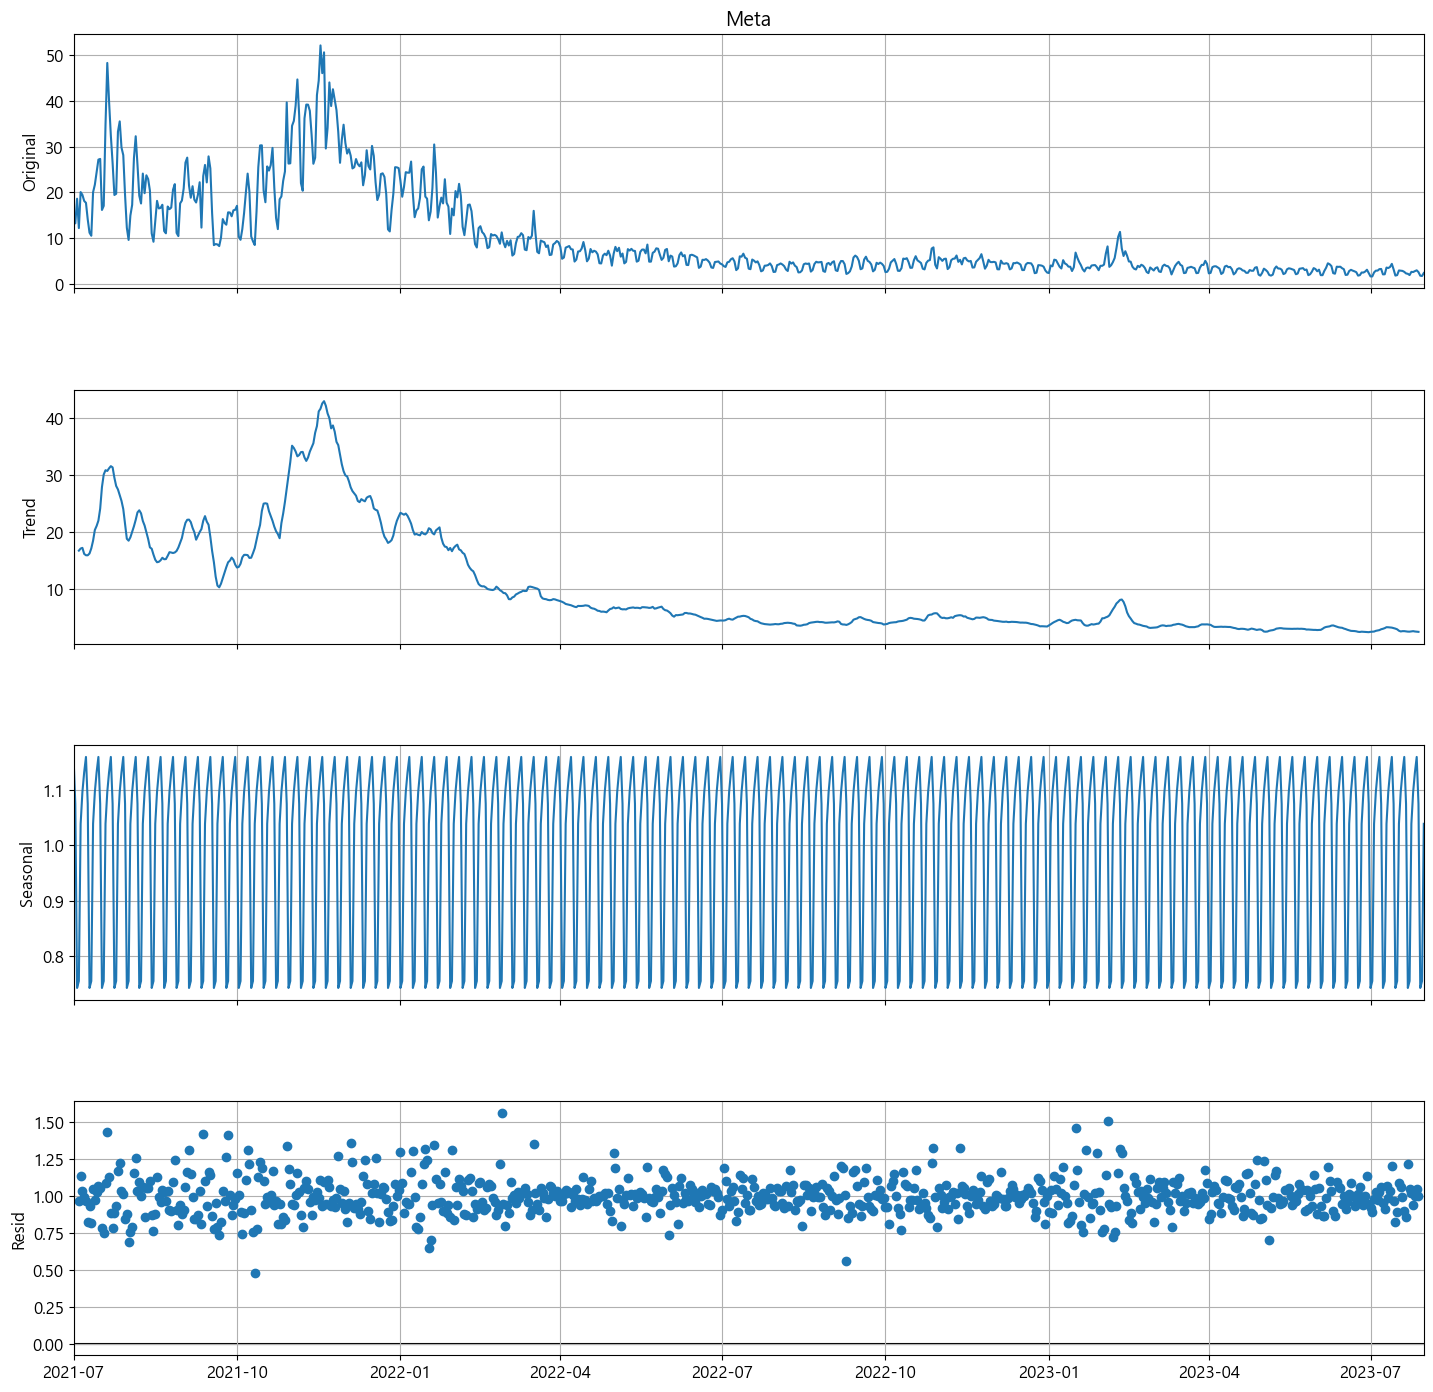

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.61509 |
| 유의수준(p-value)                  | 0.475306 |
| 최적차수(num of lags)              |       14 |
| 관측치 개수(num of observations)   |      746 |
| 기각값(Critical Values) 1%         | -3.43915 |
| 기각값(Critical Values) 5%         | -2.86542 |
| 기각값(Critical Values) 10%        | -2.56884 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+


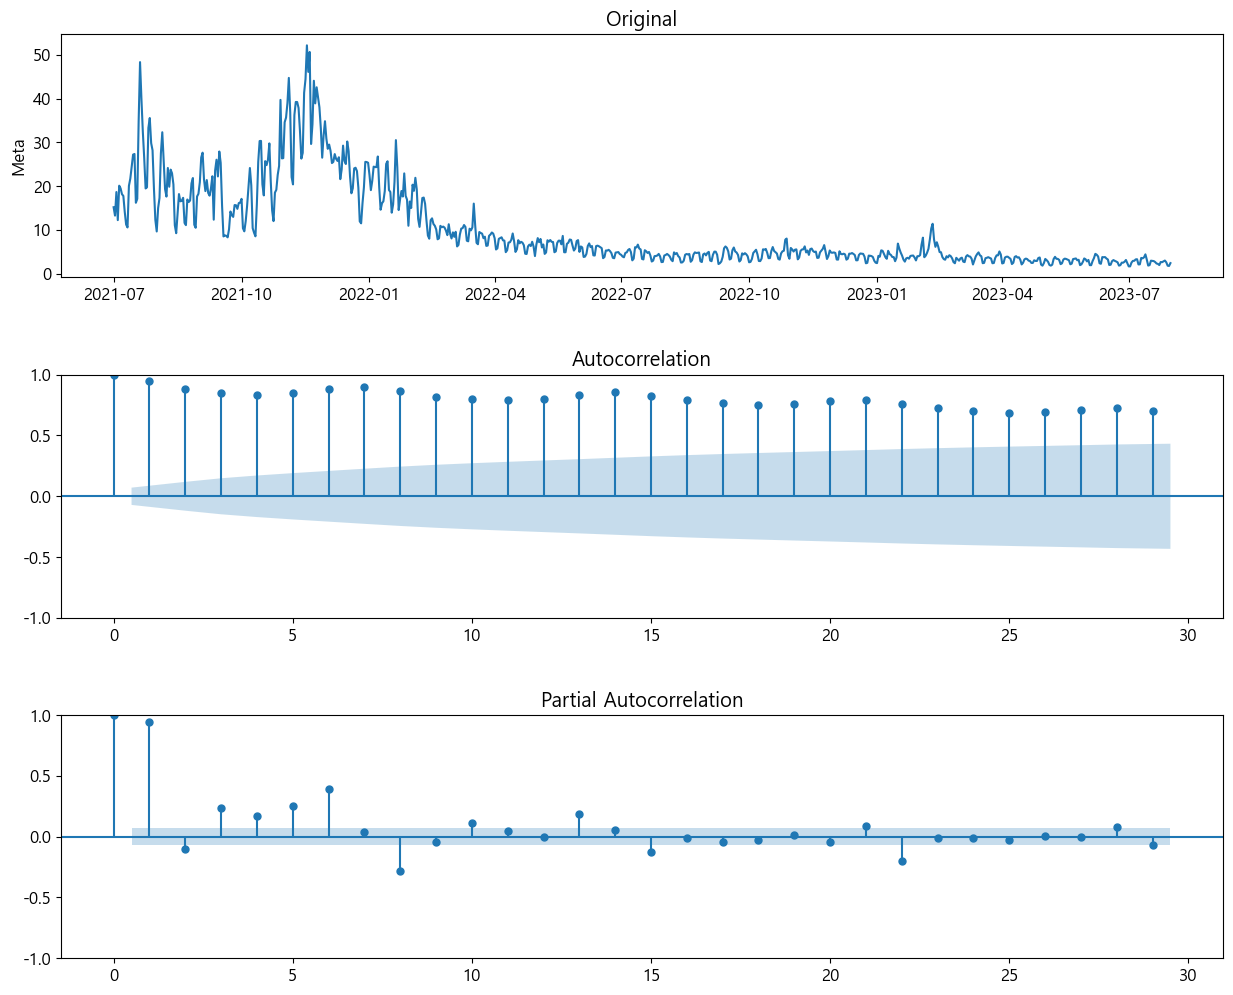

애플
결측치 수: 0


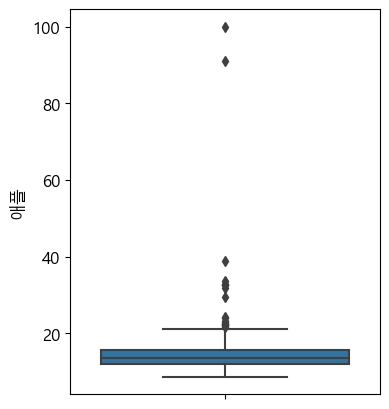

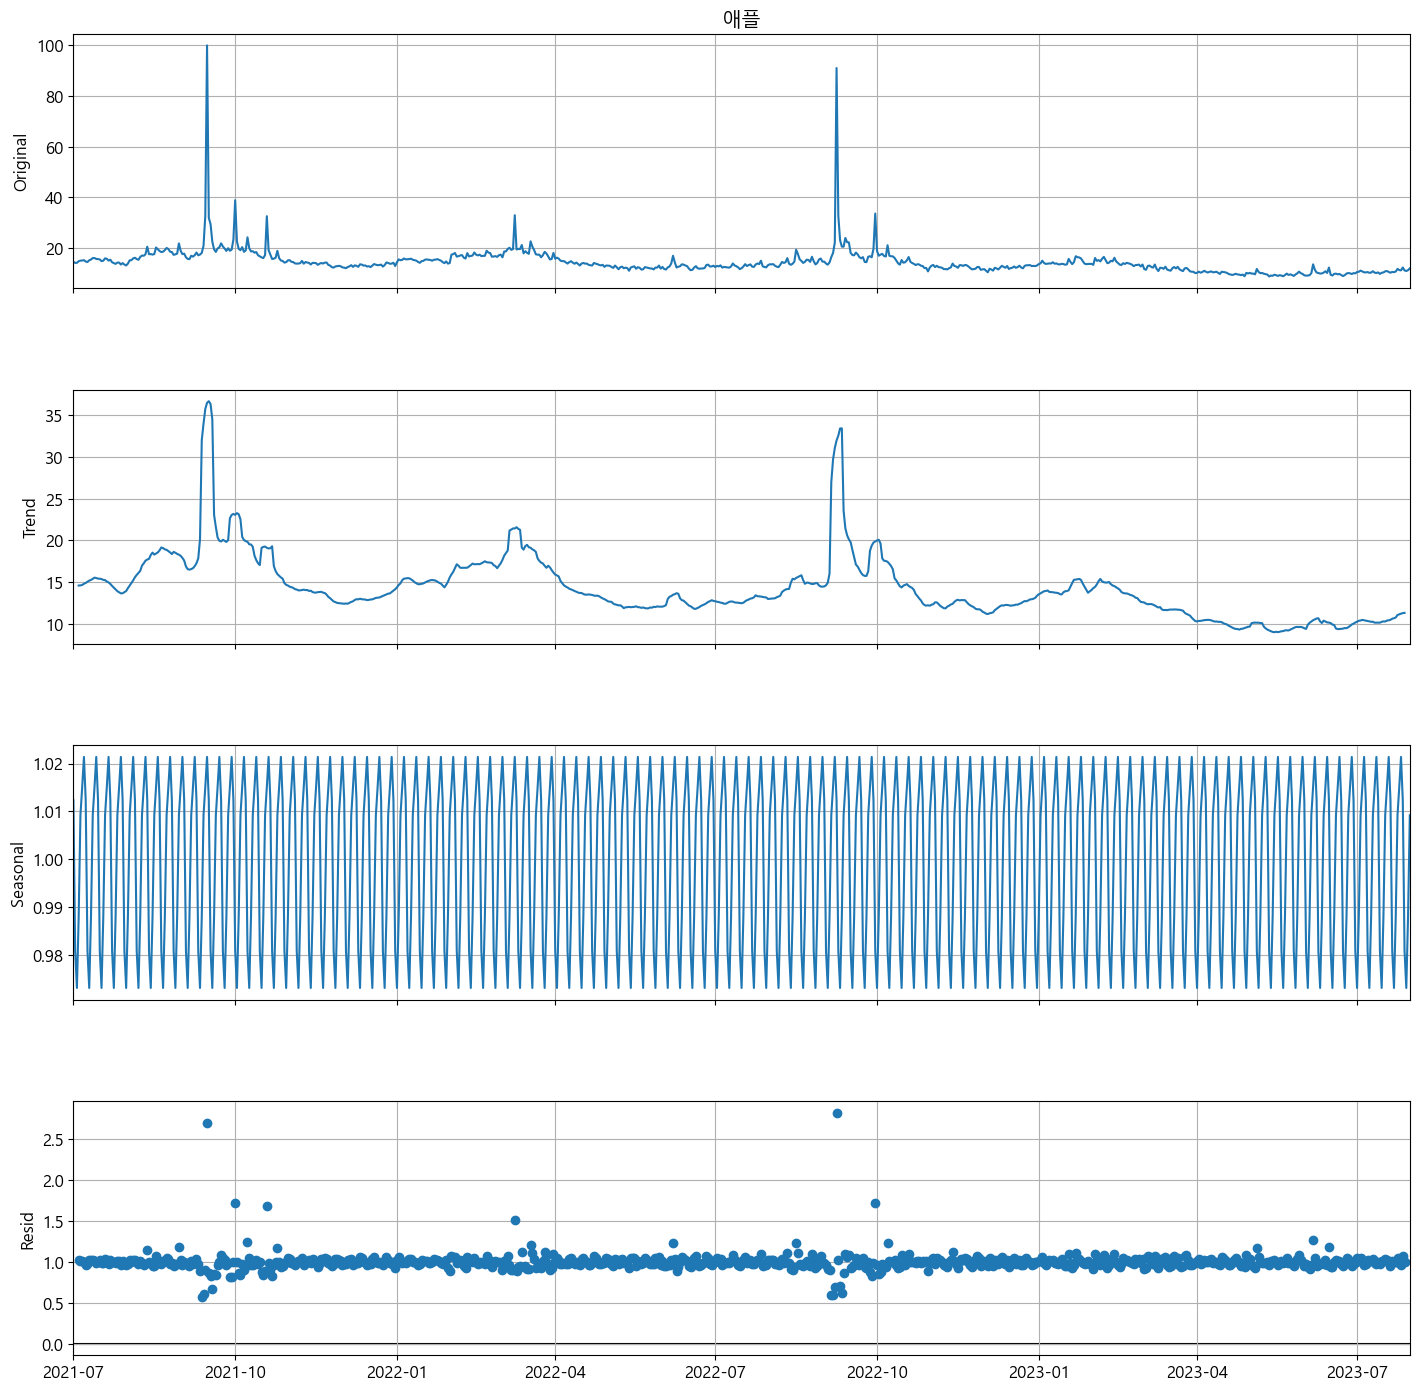

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          |  -2.72844 |
| 유의수준(p-value)                  | 0.0692451 |
| 최적차수(num of lags)              |        15 |
| 관측치 개수(num of observations)   |       745 |
| 기각값(Critical Values) 1%         |  -3.43916 |
| 기각값(Critical Values) 5%         |  -2.86543 |
| 기각값(Critical Values) 10%        |  -2.56884 |
| 데이터 정상성 여부(0=Flase,1=True) |         0 |
+------------------------------------+-----------+


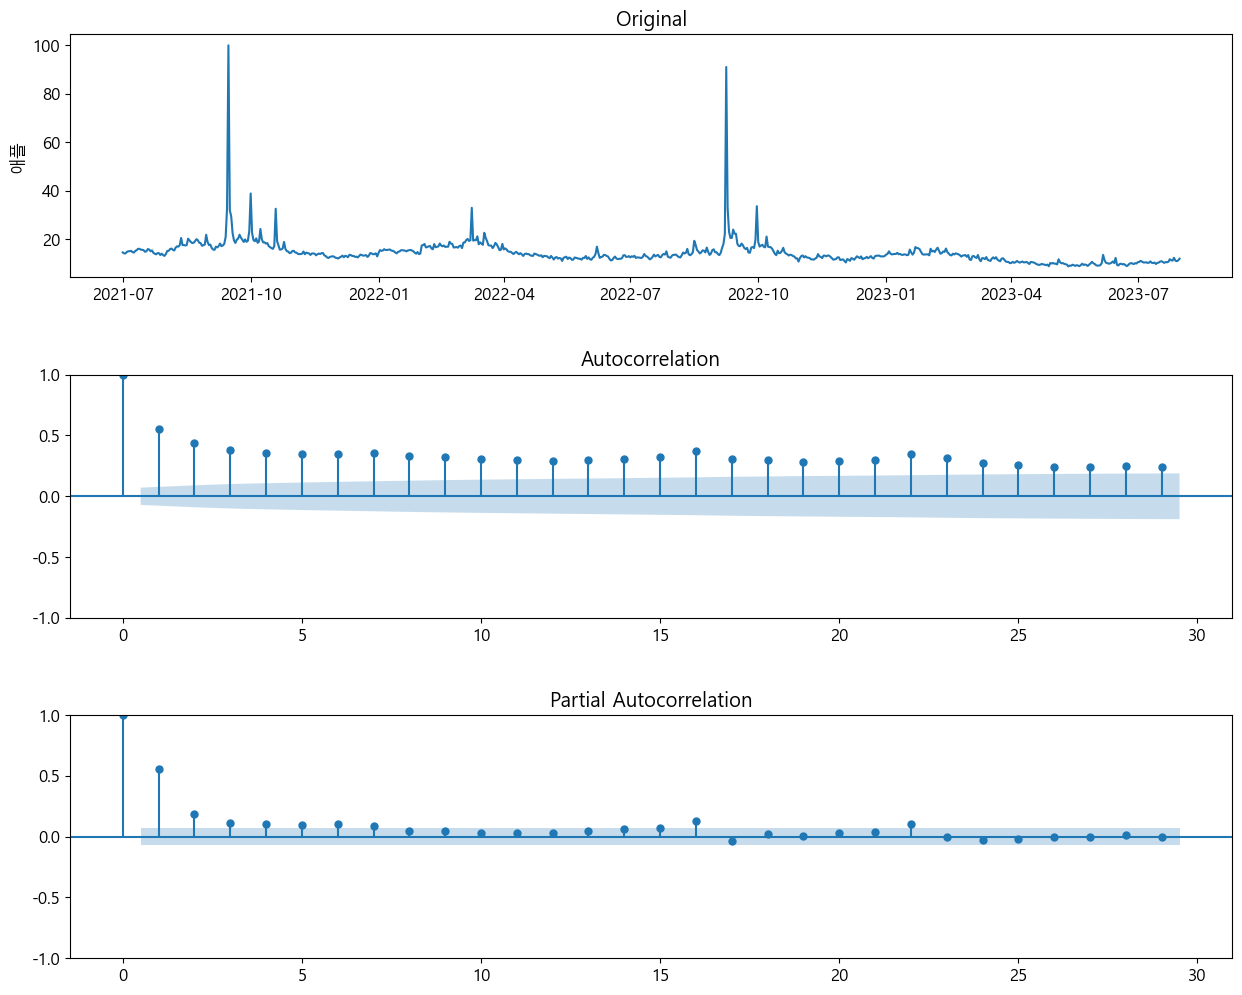

In [37]:
for c in df2.columns:
    print("=========================================")
    print(c)
    print("=========================================")

    exp_time_data(df2, c, "m")


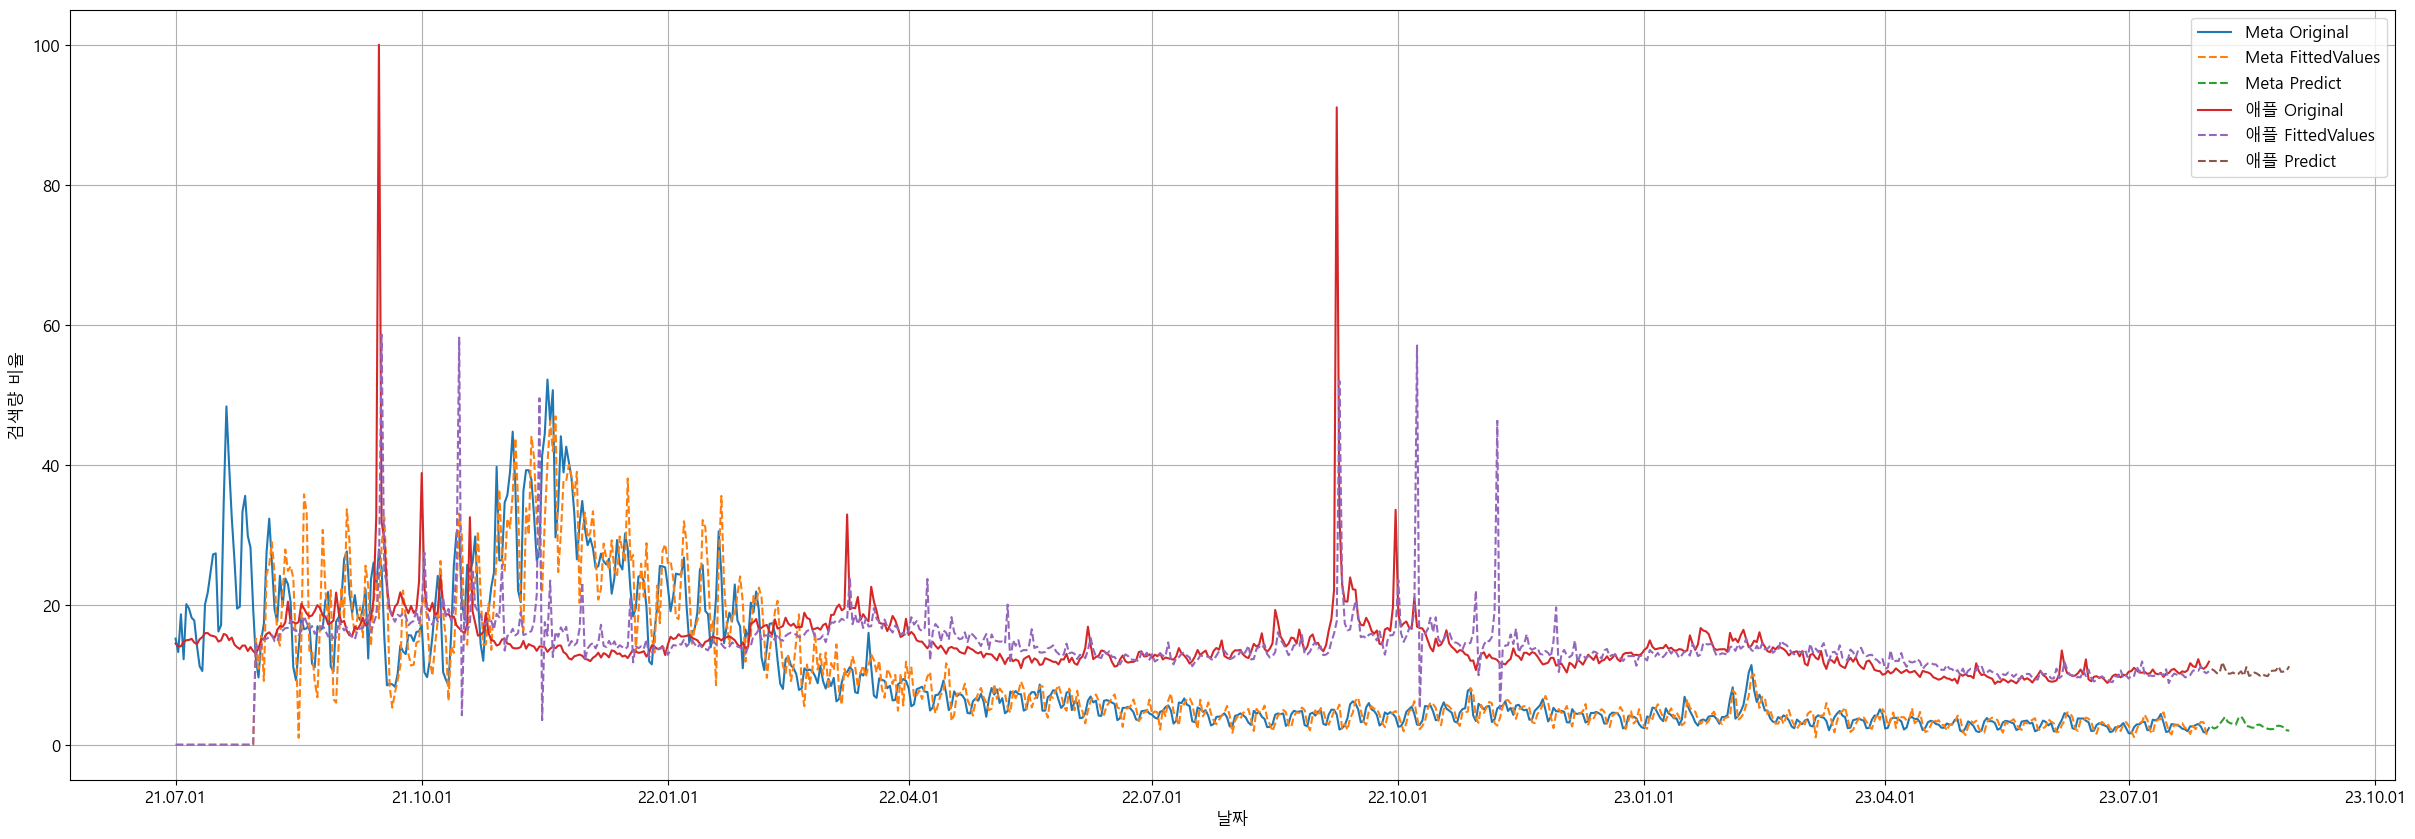

In [38]:
plt.figure(figsize=(30,10))

for c in df2.columns:
    # 모델 구성
    model = ARIMA(df2[c], order=(1,0,0), seasonal_order=(1,1,0,30))
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 예측값
    fc = fit.forecast(30)
    
    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues' % c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()